<h1>Logistic Regression</h1>
In this notebook, we will apply logistic regression (despite having regression in its name, it is referred to as a classification algorithm mainly) on the same boston house dataset. The original dataset was for regression task, we will convert it into a <strong>binary classification</strong> task [hypothetical].

1. We will look at hyper-parameter tuning during modelling.
2. The evaluation metrics (also loss functions) related to classification task, and their importance in gauging the model's performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

In [2]:
# using boston house price dataset: this is available from sklearn library
boston = load_boston()
df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
# changing the target: to convert it into a hypothetical classification algorithm
# say, if the PRICE > $300,000 then the house is considered expensive
# our classification task is to check if a house will be expensive/not by just looking at the features.
df['EXPENSIVE'] = boston['target']
df['EXPENSIVE'] = df['EXPENSIVE'].apply(lambda x: 'YES' if x>30 else 'NO')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,EXPENSIVE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,NO
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,NO
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,YES
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,YES
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,YES


<h1>Initial Data Analysis and Explanatory Data Analysis</h1>
Similar analysis holds as the <a href='linear_regression_2.ipynb'>previous notebook</a>, and the findings apply here too. We are omitting that part in this notebook but remember this is quite an important step for any ML task. Additionally, in this task, the class balance/imbalance of the target variable should also be checked.

In [3]:
print('Proportion of YES: {:.3f}%, Proportion of NO: {:.3f}%'.format(df[df['EXPENSIVE']=='YES']['EXPENSIVE'].count()*100/df.shape[0], df[df['EXPENSIVE']=='NO']['EXPENSIVE'].count()*100/df.shape[0]))
df['EXPENSIVE'].describe()

Proportion of YES: 16.601%, Proportion of NO: 83.399%


count     506
unique      2
top        NO
freq      422
Name: EXPENSIVE, dtype: object

<h1>Tasks</h1>

In a typical ML task, you actually should reflect here because of the class imbalance - 'Not Expensive' houses dominate the dataset. In an ideal dataset, you should generally  have equal proportion of 'YES' and 'NO' for a binary classification task. If not, you should at least try to resolve it [generating more samples, undersamplling the major class, oversampling the minor class, synthetically create more samples etc.] - all these without comprising the 'validity' of the data, i.e., throwing away important information [undersampling], introducing 'false information' inside the dataset [the way you introduced more samples, etc.]. This is quite an important part, and after completing this notebook, you should try to come back to this step, and may try to resolve this issue and evaluate the model's performance again.

For example, without any training, if an estimator just predicts the house as 'NOT EXPENSIVE' for any input, then the model's accuracy will be 83.399% for this dataset!!! Without resolving this imbalance, it is likely that the trained classifier may be inclined towards predicting the house to be 'NOT EXPENSIVE' too since this imbalance will impact its learning.

We will proceed with our <strong>binary classification task</strong> anyway without resolving this.

<h1>Modelling (with hyper-parameter tuning)</h1>

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter("ignore") # for GridSearchCV: some of its combination throws warning which is fine (they are not appropriate combination)

# dropping the EXPENSIVE column [target variable]
X = df.drop(['EXPENSIVE'], axis = 1)
#X = df[['RM']] # use/uncomment this line if you want to use a single feature!!!
y = df['EXPENSIVE'].apply(lambda x: 0 if x=='NO' else 1) # convering the categorical target into numeric: EXPENSIVE = 1, NOT EXPENSIVE = 0

# standardisation of the features: extremely important so that the effect of 'magnitude difference' between features do not affect the optimisation of weights are not given more importance
sc = StandardScaler()
X = sc.fit_transform(X)

# separating of training and testing set: 80-20 separation
# random_state parameter is given to keep the same randomised splitting: important when you are creating the model
# and want to keep a specific separation across multiple runs. Once modelling/evaluation is completed, you can actually
# remove this parameter to generate random splitting in each run of this notebook
# for classification, stratification on y [target] is important so that equal proportion of classes exist in both training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# hyper-parameter tuning using in-built GridSearchCV
# pipeline is used to standardisation and also creating the normal instance of a LogisticRegression
# This may take a while: good to set the max_iter parameter as well...
param_grid=[{'C': np.logspace(-4,4,15)},
           {'penalty': ['l1', 'l2']},
           {'solver': ['lbfgs', 'liblinear', 'adam']},
          {'max_iter': [10000]}]

lr = LogisticRegression()

# refer to sklearn documentation for more details:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=10, scoring='recall', refit=True) # you can change scoring function that will impact the estimator
grid = grid.fit(X_train, y_train)
print('Best estimator: {}\nWeights: {}, Intercept: {}\nBest params: {}\nScorer: {}'.format(grid.best_estimator_, grid.best_estimator_.coef_, grid.best_estimator_.intercept_,grid.best_params_, grid.scorer_))
print('Available parameters for the estimator (fine-tuning): ',lr.get_params().keys())

Best estimator: LogisticRegression()
Weights: [[ 0.14513444  0.39202927 -0.97854289  0.1618424   0.02479979  1.47605734
   0.35606539 -0.67879687  0.95373518 -0.49196683 -0.73602807  0.1204218
  -2.43396895]], Intercept: [-4.37431992]
Best params: {'C': 1.0}
Scorer: make_scorer(recall_score, average=binary)
Available parameters for the estimator (fine-tuning):  dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


<h1>Evaluation</h1>

In [5]:
# model evaluation for training set
y_train_predict = grid.predict(X_train)
print("Training SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_train, y_train_predict), precision_score(y_train, y_train_predict), recall_score(y_train, y_train_predict), f1_score(y_train, y_train_predict)))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_train, y_train_predict)))

# model evaluation for testing set
y_test_predict = grid.predict(X_test)

print("\nTesting SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_test, y_test_predict), precision_score(y_test, y_test_predict), recall_score(y_test, y_test_predict), f1_score(y_test, y_test_predict)))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_test_predict)))

Training SET
--------------------------------------
Accuracy: 0.953, Precision: 0.853, Recall: 0.866, F1 Score: 0.859
Confusion Matrix:
 [[327  10]
 [  9  58]]

Testing SET
--------------------------------------
Accuracy: 0.961, Precision: 0.882, Recall: 0.882, F1 Score: 0.882
Confusion Matrix:
 [[83  2]
 [ 2 15]]


ROC AUC (Training)=0.981
ROC AUC (Testing)=0.982


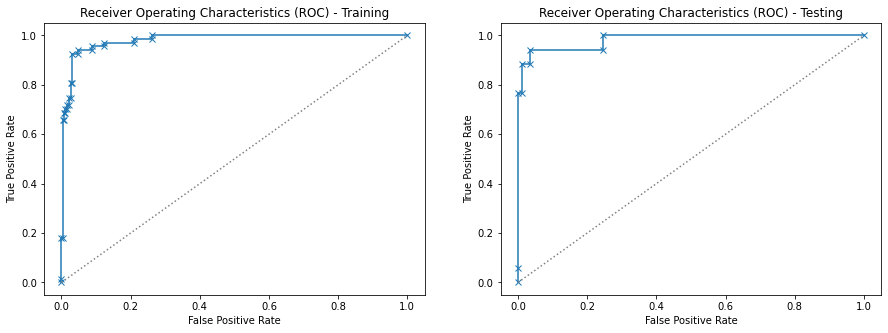

In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
lr_probs_train = grid.predict_proba(X_train)
lr_probs_test = grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_train = lr_probs_train[:, 1]
lr_probs_test = lr_probs_test[:, 1]

print('ROC AUC (Training)={:.3f}'.format(roc_auc_score(y_train, lr_probs_train)))
print('ROC AUC (Testing)={:.3f}'.format(roc_auc_score(y_test, lr_probs_test)))

lr_fpr_train, lr_tpr_train, _ = roc_curve(y_train, lr_probs_train)
lr_fpr_test, lr_tpr_test, _ = roc_curve(y_test, lr_probs_test)

# plot the roc curve for the model
_ = plt.figure(figsize=(15, 5))
ax1 =plt.subplot(121)
_ = ax1.plot(lr_fpr_train, lr_tpr_train, marker='x')
_ = ax1.plot([0,1], [0, 1], 'gray', linestyle=':', marker='')
_ = ax1.set_title('Receiver Operating Characteristics (ROC) - Training')
_ = ax1.set_xlabel('False Positive Rate')
_ = ax1.set_ylabel('True Positive Rate')

ax2 = plt.subplot(122)
_ = ax2.plot(lr_fpr_test, lr_tpr_test, marker='x')
_ = ax2.plot([0,1], [0, 1], 'gray', linestyle=':', marker='')
_ = ax2.set_title('Receiver Operating Characteristics (ROC) - Testing')
_ = ax2.set_xlabel('False Positive Rate')
_ = ax2.set_ylabel('True Positive Rate')

<h3>Inference Probabilities</h3>

In [7]:
#print(lr_probs_test[0:20])
#here, we create a pandas dataframe to demonstrate the computed probabilities for a house of being expensive in order to relate it to the lecture notes
#remember, logistic regression's regressed part is on these probabilities!
expensive = {1: 'YES', 0:'NO'} # just to revert back y_test's 0,1 numeric to YES/NO categorical values for display
pb_df = pd.DataFrame({'EXPENSIVE':[expensive[numeric_cat] for numeric_cat in y_test[0:]], 'PREDICTED PROBABILITY OF BEING EXPENSIVE':lr_probs_test[0:]}, columns=['EXPENSIVE', 'PREDICTED PROBABILITY OF BEING EXPENSIVE'])
pb_df.iloc[10:20].head(10)

,EXPENSIVE,PREDICTED PROBABILITY OF BEING EXPENSIVE
10,YES,0.542816
11,NO,0.173117
12,NO,0.003434
13,NO,0.000922
14,NO,0.000968
15,NO,0.254443
16,YES,0.802174
17,NO,0.000014
18,NO,0.000225
19,NO,0.011674


In [8]:
# we will break down the computation of the first probability here [0.542816] corresponding to the testing record X_test[10:11]
# and relate it to the different elements of the logistic regression algorithm [refer to Slide 4 of the lecture notes - especially the diagram]

# we already know the optimum weights, w_i [model parameters] after training, they are stored as grid.best_estimator_.coef_ [since we have used Grid Search]
# depending on how you train them [with or without grid search], and the name of the variables, this may vary......
# grid.best_estimator_.intercept_ will hold the w_0

# compute: net input (z): refer to Slide 4 of lecture notes [it is just the weighted sum, z = \sum_{j=1}^m w_j.x_j + w_0]
z = np.dot(X_test[10:11].tolist()[0], grid.best_estimator_.coef_[0])+grid.best_estimator_.intercept_[0]

# compute: sigma(z): the probability / activation function output - again refer to Slide 4 of lecture notes....
sigma_z = 1 / (1+ np.exp(-z))
print("For record X_test[10], our manually computed probability: {}, sklearn's returned probability: {}".format(sigma_z, grid.predict_proba(X_test[10:11])[:,1][0]))

# you may also want to look at the False Positive records predicted probabilities [e.g., NO in actual Expensive column but probability of prediction will be >= 0.5]
# we already know there will be two False Positives for the testing set [from the confusion matrix above]
print('The two false positives are below: ')
pb_df[(pb_df['EXPENSIVE'] == 'NO') & (pb_df['PREDICTED PROBABILITY OF BEING EXPENSIVE'] >= 0.5)]
# you can trace back to the X_test to check the features [standardised] - you may need to 'de'-standardise to check the actual feature values
# also, do the same for false negatives - from confusion matrix, you know there will be two

For record X_test[10], our manually computed probability: 0.5428158532370662, sklearn's returned probability: 0.5428158532370662
The two false positives are below: 


,EXPENSIVE,PREDICTED PROBABILITY OF BEING EXPENSIVE
47,NO,0.640202
58,NO,0.509722


In [9]:
# computing odds (in many books/articles, you may find it to be 'logit' function)
# if P(Y==1|X) can be denoted as 'p', then odds (logit) = p / (1-p)
# it has similar interpretation as 'Linear Regression', for example, in lecture slides we have seen by how much 1-unit (1£) of Bills (X) may increase/decrease the Tips (y)
# however, this was more straight-forward in 'Linear Regression' since the relationship between 'predictor' (X) and the response variable (y) was regressed with linear activation function.

# In logistic regression, we used non-linear activation function - so this relationship between 'predictor' (X) and response variable (y) are not linear.
# we try to find how much 1-unit increase (e.g., say RM - average number of rooms predictor variable) will increase/decrease the odds - this will be the following:
# exp(weight associated with RM) - RM is the 5th index inside the weight coef_
# you can find one detailed explanation here: https://stats.stackexchange.com/questions/29325/what-is-the-difference-between-linear-regression-and-logistic-regression
# the computed weights are for standardised features - needs to be scaled by std (standard deviation)
print('The increase in odds by increasing 1-unit of average number of rooms (predictor RM) should be: {:.5f}'.format(np.exp((grid.best_estimator_.coef_[0][5]/np.sqrt(sc.var_[5])))))
# we can actually verify it by taking one record, and computing p/(1-p) using the model for both original RM and new (RM+1)  
orig_prob = grid.predict_proba(X_test[10].reshape(1, -1))  # if it is a single record, requires reshaping
# the features were standardised by (x - u) / s by StandardScaler() - documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# increasing x by 1 will mean increasing standardised feature by 1/s
X_test[10][5] = X_test[10][5] + (1/np.sqrt(sc.var_[5]))
new_prob = grid.predict_proba(X_test[10].reshape(1, -1))
print('The computed gain using the probabilities: {:.5f}'.format((new_prob[0, 1]/new_prob[0, 0])/(orig_prob[0, 1]/orig_prob[0, 0])))
print('Means we gain more than 8 times odds of  being an Expensive house by just increasing 1-unit of average number of rooms (RM feature)\nSimilar analysis can be performed regarding other features as well.')

The increase in odds by increasing 1-unit of average number of rooms (predictor RM) should be: 8.18971
The computed gain using the probabilities: 8.18971
Means we gain more than 8 times odds of  being an Expensive house by just increasing 1-unit of average number of rooms (RM feature)
Similar analysis can be performed regarding other features as well.


### Reflection
We should have some ideas by now that the learnt parameters are nothing but the model parameters [weights] which were computed using an optimisation algorithm [solver]
on a loss function [the loss function preferrably should be convex to ENSURE reaching globally optimum weights]. We discussed one solver in lecture notes: Gradient Descent.
If the loss function is not convex, the ML algorithm can converge to a local optimum. But remember, it may not be always possible to find convex loss function for all the ML algorithms. Some 'solvers' try to take this into consideration, and still try to find the best possible weights! In the lecture slides, you were asked to research on the various solvers that are available as 'options' in scikit-learn library.

<h1>Conclusion</h1>

1. What do you feel about the model's performance looking at the various evaluation metrics?<br/>
2. Which metric can be considered as the estimator's performance indicator (accuracy/recall/precision/f1/ROC)?<br/>
2. Do change the 'scoring' metric of GridSearchCV to observe the changes in evaluaton metrics.<br/>
4. You should try to optimise the hyper-parameters of any ML algorithm for a given use-case - one simple example is provided here. EDA can provide valuable insights in terms of ideas of which hyper-parameters can be important.
5. What do you feel about the feature RM's importance in predicting the house prices looking at the interpretation inside 'Inference Probabilties' section?